# Emission Measure
In this notebook, we'll generate the emission measure slope maps for each of our heating cases and save them as FITS files.

In [2]:
import os
import sys
import glob
import copy

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
from sunpy.map import Map,GenericMap
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed
import dask.array as da

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [3]:
cluster = distributed.LocalCluster(n_workers=32,threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43297 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [33]:
channels = [94,131,171,193,211,335]
intensity_file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/nei/SDO_AIA/{}/map_t{:06d}.fits'
emslope_file_format = '/storage-home/w/wtb2/projects/synthetic-observables-paper-models/paper/data/{}/em_slope.fits'

Next, set up the temperature bins.

In [6]:
temperature_bin_edges = 10.**np.arange(5.5,7.5,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [7]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [8]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Now, we'll go through each heating case and compute the emission measure distribution.

### High

In [9]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('high_frequency', c, i) for i in range(500,2500)]) for c in channels])

In [10]:
maps = [cube[c].average() for c in channels]

In [11]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [12]:
em_high = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

In [41]:
slope_map = em_high.make_slope_map(
    temperature_bounds=[10**(5.8), 10**(6.4)]*u.K,
    em_threshold=1*u.cm**-5,
    rsquared_tolerance=0.9
)
slope_map.save(emslope_file_format.format('high_frequency'))

## Intermediate 

In [27]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('intermediate_frequency', c, i) for i in range(500,2500)]) for c in channels])

In [28]:
maps = [cube[c].average() for c in channels]

In [29]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [30]:
em_intermediate = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

In [42]:
slope_map = em_intermediate.make_slope_map(
    temperature_bounds=[10**(5.8),10**(6.4)]*u.K,
    em_threshold=1*u.cm**-5,
    rsquared_tolerance=0.9
)
slope_map.save(emslope_file_format.format('intermediate_frequency'))

## Low

In [34]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('low_frequency', c, i) for i in range(500,2500)]) for c in channels])

In [35]:
maps = [cube[c].average() for c in channels]

In [36]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [37]:
em_low = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

In [43]:
slope_map = em_low.make_slope_map(
    temperature_bounds=[10**(5.8),10**(6.4)]*u.K,
    em_threshold=1*u.cm**-5,
    rsquared_tolerance=0.9
)
slope_map.save(emslope_file_format.format('low_frequency'))

## Comparison 
Make some figures to compare the three cases

Plot the three slope maps

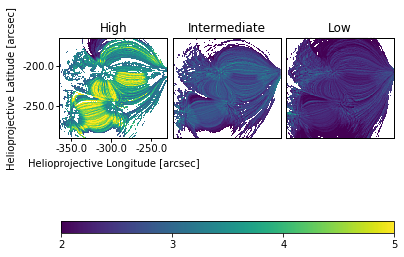

In [47]:
fig = plt.figure()
cax = fig.add_axes([0.13, 0.0, 0.77, 0.04])
labels=['High','Intermediate','Low']
opts = {'cmap': 'viridis', 'vmin': 2, 'vmax': 5, 'title': False, 'annotate': False}
slope_opts = {'temperature_bounds': [10**(5.8),10**(6.4)]*u.K,
              'em_threshold': 1e23*u.cm**-5,
              'rsquared_tolerance': 0.9
             }
for i,em in enumerate([em_high,em_intermediate,em_low]):
    slope_map = em.make_slope_map(**slope_opts)
    slope_map = slope_map.submap(SkyCoord(Tx=-365*u.arcsec,Ty=-290*u.arcsec,frame=slope_map.coordinate_frame),
                                 SkyCoord(Tx=-230*u.arcsec,Ty=-165*u.arcsec,frame=slope_map.coordinate_frame))
    ax = fig.add_subplot(1,len(labels),i+1,projection=slope_map)
    im = slope_map.plot(axes=ax,**opts)
    ax.grid(alpha=0)
    lon,lat = ax.coords
    if i > 0:
        lon.set_ticks_visible(False)
        lon.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)
    else:
        lat.set_ticks(number=3)
        lon.set_axislabel('Helioprojective Longitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lat.set_axislabel('Helioprojective Latitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
    ax.set_title(labels[i])
plt.subplots_adjust(hspace=0.,wspace=0.05)
cbar = fig.colorbar(im,cax=cax,orientation='horizontal');
cbar.set_ticks([2,3,4,5])
#fig.savefig('figures/em_slope_maps.pdf')

Now, overplot the three slope distributions

Text(0,0.5,'Number of Pixels')

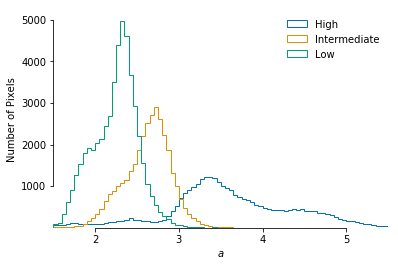

In [49]:
sys.path.append('../paper/python/')
from formatting import heating_palette
fig = plt.figure()
ax = fig.gca()
bins = np.arange(1,6,0.05)
bin_centers = (bins[:-1] + bins[1:])/2
opts = {'bins': bins, 'histtype': 'step','density':False, 'lw':1}
for i,em in enumerate([em_high,em_intermediate,em_low]):
    slope_map = em.make_slope_map(**slope_opts)
    d = slope_map.data.flatten()
    h,b,_ = ax.hist(d[~np.isnan(d)],**opts,color=heating_palette()[i],label=labels[i])
ax.set_xlim(1.5,5.5);
ax.set_xticks([2,3,4,5])
ax.legend(frameon=False,loc=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim([50,5001])
ax.set_yticks(ax.get_yticks()[1:-1])
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-1])
ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'Number of Pixels')
#fig.savefig('figures/em_slope_histograms.pdf')